<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA6_Phase1/blob/main/EVA6_S6_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Jun 11 14:57:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Mounting the drive and copying the code from github to drive
from google.colab import drive 
drive.mount('/content/gdrive')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA6_Phase1

Mounted at /content/gdrive
Cloning into 'Deep_Learning_EVA6_Phase1'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 220 (delta 114), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (220/220), 7.33 MiB | 4.63 MiB/s, done.
Resolving deltas: 100% (114/114), done.


In [3]:
%cd Deep_Learning_EVA6_Phase1/src
! ls

/content/Deep_Learning_EVA6_Phase1/src
models.py  README.md  test_loss.py  train_loss.py  utilities.py


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
# Import required src files
import models, utilities, train_loss, test_loss

## Data Transformations

In [6]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                       transforms.RandomRotation((-7,7),fill=(1,)),                                       
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [7]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Model Params


In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [10]:
bn_model = models.S6_CNNModel(3, 10, 0.05, 'Batch').to(device)
summary(bn_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           CNNNorm-4           [-1, 16, 26, 26]               0
           Dropout-5           [-1, 16, 26, 26]               0
         CNNBlocks-6           [-1, 16, 26, 26]               0
            Conv2d-7           [-1, 16, 24, 24]           2,304
              ReLU-8           [-1, 16, 24, 24]               0
       BatchNorm2d-9           [-1, 16, 24, 24]              32
          CNNNorm-10           [-1, 16, 24, 24]               0
          Dropout-11           [-1, 16, 24, 24]               0
        CNNBlocks-12           [-1, 16, 24, 24]               0
        MaxPool2d-13           [-1, 16, 12, 12]               0
           Conv2d-14           [-1, 16,

In [11]:
print(bn_model)

S6_CNNModel(
  (cnn_block0): Sequential(
    (0): CNNBlocks(
      (cnn): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (relu): ReLU()
      (dropout): Dropout(p=0.05, inplace=False)
      (norm): CNNNorm(
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (cnn_block1): Sequential(
    (0): CNNBlocks(
      (cnn): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (relu): ReLU()
      (dropout): Dropout(p=0.05, inplace=False)
      (norm): CNNNorm(
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_block_2_3_4): Sequential(
    (0): CNNBlocks(
      (cnn): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (relu): ReLU()
      (dropout): Dropout(p=0.05, inplace=False)
      (norm): CNNNorm(
        (norm): BatchNor

In [12]:
ln_model = models.S6_CNNModel(3, 10, 0.05, 'Layer').to(device)
summary(ln_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         GroupNorm-3           [-1, 16, 26, 26]              32
           CNNNorm-4           [-1, 16, 26, 26]               0
           Dropout-5           [-1, 16, 26, 26]               0
         CNNBlocks-6           [-1, 16, 26, 26]               0
            Conv2d-7           [-1, 16, 24, 24]           2,304
              ReLU-8           [-1, 16, 24, 24]               0
         GroupNorm-9           [-1, 16, 24, 24]              32
          CNNNorm-10           [-1, 16, 24, 24]               0
          Dropout-11           [-1, 16, 24, 24]               0
        CNNBlocks-12           [-1, 16, 24, 24]               0
        MaxPool2d-13           [-1, 16, 12, 12]               0
           Conv2d-14           [-1, 16,

In [13]:
print(ln_model)

S6_CNNModel(
  (cnn_block0): Sequential(
    (0): CNNBlocks(
      (cnn): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (relu): ReLU()
      (dropout): Dropout(p=0.05, inplace=False)
      (norm): CNNNorm(
        (norm): GroupNorm(1, 16, eps=1e-05, affine=True)
      )
    )
  )
  (cnn_block1): Sequential(
    (0): CNNBlocks(
      (cnn): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (relu): ReLU()
      (dropout): Dropout(p=0.05, inplace=False)
      (norm): CNNNorm(
        (norm): GroupNorm(1, 16, eps=1e-05, affine=True)
      )
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_block_2_3_4): Sequential(
    (0): CNNBlocks(
      (cnn): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (relu): ReLU()
      (dropout): Dropout(p=0.05, inplace=False)
      (norm): CNNNorm(
        (norm): GroupNorm(1, 16, eps=1e-05, affine=True)
      )
    )
    (1): CNNBlocks(
      (cnn)

In [14]:
gn_model = models.S6_CNNModel(3, 10, 0.05, 'Group').to(device)
summary(gn_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         GroupNorm-3           [-1, 16, 26, 26]              32
           CNNNorm-4           [-1, 16, 26, 26]               0
           Dropout-5           [-1, 16, 26, 26]               0
         CNNBlocks-6           [-1, 16, 26, 26]               0
            Conv2d-7           [-1, 16, 24, 24]           2,304
              ReLU-8           [-1, 16, 24, 24]               0
         GroupNorm-9           [-1, 16, 24, 24]              32
          CNNNorm-10           [-1, 16, 24, 24]               0
          Dropout-11           [-1, 16, 24, 24]               0
        CNNBlocks-12           [-1, 16, 24, 24]               0
        MaxPool2d-13           [-1, 16, 12, 12]               0
           Conv2d-14           [-1, 16,

In [15]:
print(gn_model)

S6_CNNModel(
  (cnn_block0): Sequential(
    (0): CNNBlocks(
      (cnn): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (relu): ReLU()
      (dropout): Dropout(p=0.05, inplace=False)
      (norm): CNNNorm(
        (norm): GroupNorm(4, 16, eps=1e-05, affine=True)
      )
    )
  )
  (cnn_block1): Sequential(
    (0): CNNBlocks(
      (cnn): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (relu): ReLU()
      (dropout): Dropout(p=0.05, inplace=False)
      (norm): CNNNorm(
        (norm): GroupNorm(4, 16, eps=1e-05, affine=True)
      )
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_block_2_3_4): Sequential(
    (0): CNNBlocks(
      (cnn): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (relu): ReLU()
      (dropout): Dropout(p=0.05, inplace=False)
      (norm): CNNNorm(
        (norm): GroupNorm(4, 16, eps=1e-05, affine=True)
      )
    )
    (1): CNNBlocks(
      (cnn)

# Training and Testing



In [16]:
from torch.optim.lr_scheduler import StepLR
m_parms = {'cnn_blocks'  :3, 
            'classes'    :10, 
             'dropout'   :0.05}

In [17]:
norm_type = {'Batch' : (0.001, 0.0005), 'Layer' : (0, 0.0005), 'Group' : (0.001, 0)}
# Tuple represents L1 & L2 factors eg : (L1, L2) = (0.001, 0.0005)

for norm in norm_type:
    print(f'******Training for Normalization type : {norm}, L1={norm_type[norm][0]}, L2={norm_type[norm][1]}*******')
    EPOCHS = 25
    model =  models.S6_CNNModel(m_parms['cnn_blocks'], m_parms['classes'], m_parms['dropout'], norm).to(device)  
    optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.8, weight_decay = norm_type[norm][1])
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
    L1 = norm_type[norm][0]

    if norm == 'Batch':  # BN + L1 + L2
        bn_train_stats, bn_test_stats = utilities.stats_collector(), utilities.stats_collector()
        train = train_loss.train_losses(model, device, train_loader, bn_train_stats, optimizer, EPOCHS)
        test  = test_loss.test_losses(model, device, test_loader, bn_test_stats, EPOCHS)
    elif norm == 'Layer': # LN + L2
        ln_train_stats, ln_test_stats = utilities.stats_collector(), utilities.stats_collector()
        train = train_loss.train_losses(model, device, train_loader, ln_train_stats, optimizer, EPOCHS)  
        test = test_loss.test_losses(model, device, test_loader, ln_test_stats, EPOCHS)
    elif norm == 'Group': # GN + L1
        gn_train_stats, gn_test_stats = utilities.stats_collector(), utilities.stats_collector()
        train = train_loss.train_losses(model, device, train_loader, gn_train_stats, optimizer, EPOCHS)  
        test = test_loss.test_losses(model, device, test_loader, gn_test_stats, EPOCHS)                 

    for epoch in range(EPOCHS):
        print(f'EPOCH: {epoch}, normalization: {norm}')
        train.s6_train(epoch, L1_factor=L1)
        test.s6_test(epoch)        

  0%|          | 0/469 [00:00<?, ?it/s]

******Training for Normalization type : Batch, L1=0.001, L2=0.0005*******
EPOCH: 0, normalization: Batch


Loss=0.07449159026145935 Batch_id=468 Train Accuracy=90.52: 100%|██████████| 469/469 [00:42<00:00, 11.12it/s]

Train set: Epoch : 0/25 Average loss: 0.0000, Train Accuracy: 90.52



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 0/25 Average loss: 0.0922, Test Accuracy: 97.6
EPOCH: 1, normalization: Batch


Loss=0.09056288748979568 Batch_id=468 Train Accuracy=97.92: 100%|██████████| 469/469 [00:42<00:00, 10.93it/s]

Train set: Epoch : 1/25 Average loss: 0.0000, Train Accuracy: 97.92



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 1/25 Average loss: 0.0548, Test Accuracy: 98.4
EPOCH: 2, normalization: Batch


Loss=0.10096201300621033 Batch_id=468 Train Accuracy=98.36: 100%|██████████| 469/469 [00:42<00:00, 10.92it/s]

Train set: Epoch : 2/25 Average loss: 0.0000, Train Accuracy: 98.36



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 2/25 Average loss: 0.0370, Test Accuracy: 98.88
EPOCH: 3, normalization: Batch


Loss=0.08128023892641068 Batch_id=468 Train Accuracy=98.60: 100%|██████████| 469/469 [00:42<00:00, 10.91it/s]

Train set: Epoch : 3/25 Average loss: 0.0000, Train Accuracy: 98.6



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 3/25 Average loss: 0.0316, Test Accuracy: 99.06
EPOCH: 4, normalization: Batch


Loss=0.07253684103488922 Batch_id=468 Train Accuracy=98.67: 100%|██████████| 469/469 [00:42<00:00, 11.07it/s]

Train set: Epoch : 4/25 Average loss: 0.0000, Train Accuracy: 98.67



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 4/25 Average loss: 0.0392, Test Accuracy: 98.83
EPOCH: 5, normalization: Batch


Loss=0.03702350705862045 Batch_id=468 Train Accuracy=98.79: 100%|██████████| 469/469 [00:42<00:00, 11.08it/s]

Train set: Epoch : 5/25 Average loss: 0.0000, Train Accuracy: 98.79



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 5/25 Average loss: 0.0325, Test Accuracy: 99.02
EPOCH: 6, normalization: Batch


Loss=0.049825772643089294 Batch_id=468 Train Accuracy=98.81: 100%|██████████| 469/469 [00:42<00:00, 11.03it/s]

Train set: Epoch : 6/25 Average loss: 0.0000, Train Accuracy: 98.81



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 6/25 Average loss: 0.0306, Test Accuracy: 99.11
EPOCH: 7, normalization: Batch


Loss=0.021549899131059647 Batch_id=468 Train Accuracy=98.93: 100%|██████████| 469/469 [00:42<00:00, 11.11it/s]

Train set: Epoch : 7/25 Average loss: 0.0000, Train Accuracy: 98.93



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 7/25 Average loss: 0.0287, Test Accuracy: 99.13
EPOCH: 8, normalization: Batch


Loss=0.02482667565345764 Batch_id=468 Train Accuracy=98.94: 100%|██████████| 469/469 [00:42<00:00, 11.08it/s]

Train set: Epoch : 8/25 Average loss: 0.0000, Train Accuracy: 98.94



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 8/25 Average loss: 0.0282, Test Accuracy: 99.11
EPOCH: 9, normalization: Batch


Loss=0.036498602479696274 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:42<00:00, 10.98it/s]

Train set: Epoch : 9/25 Average loss: 0.0000, Train Accuracy: 99.0



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 9/25 Average loss: 0.0361, Test Accuracy: 98.9
EPOCH: 10, normalization: Batch


Loss=0.03718717023730278 Batch_id=468 Train Accuracy=98.97: 100%|██████████| 469/469 [00:43<00:00, 10.91it/s]

Train set: Epoch : 10/25 Average loss: 0.0000, Train Accuracy: 98.97



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 10/25 Average loss: 0.0308, Test Accuracy: 99.1
EPOCH: 11, normalization: Batch


Loss=0.015840968117117882 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:43<00:00, 10.80it/s]

Train set: Epoch : 11/25 Average loss: 0.0000, Train Accuracy: 99.0



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 11/25 Average loss: 0.0274, Test Accuracy: 99.27
EPOCH: 12, normalization: Batch


Loss=0.044396646320819855 Batch_id=468 Train Accuracy=98.99: 100%|██████████| 469/469 [00:43<00:00, 10.79it/s]

Train set: Epoch : 12/25 Average loss: 0.0000, Train Accuracy: 98.99



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 12/25 Average loss: 0.0253, Test Accuracy: 99.21
EPOCH: 13, normalization: Batch


Loss=0.06418003141880035 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:43<00:00, 10.80it/s]

Train set: Epoch : 13/25 Average loss: 0.0000, Train Accuracy: 99.05



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 13/25 Average loss: 0.0237, Test Accuracy: 99.25
EPOCH: 14, normalization: Batch


Loss=0.09450294822454453 Batch_id=468 Train Accuracy=98.98: 100%|██████████| 469/469 [00:43<00:00, 10.70it/s]

Train set: Epoch : 14/25 Average loss: 0.0000, Train Accuracy: 98.98



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 14/25 Average loss: 0.0295, Test Accuracy: 99.06
EPOCH: 15, normalization: Batch


Loss=0.024641361087560654 Batch_id=468 Train Accuracy=99.07: 100%|██████████| 469/469 [00:43<00:00, 10.68it/s]

Train set: Epoch : 15/25 Average loss: 0.0000, Train Accuracy: 99.07



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 15/25 Average loss: 0.0264, Test Accuracy: 99.2
EPOCH: 16, normalization: Batch


Loss=0.024021755903959274 Batch_id=468 Train Accuracy=99.09: 100%|██████████| 469/469 [00:44<00:00, 10.65it/s]

Train set: Epoch : 16/25 Average loss: 0.0000, Train Accuracy: 99.09



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 16/25 Average loss: 0.0264, Test Accuracy: 99.19
EPOCH: 17, normalization: Batch


Loss=0.043859656900167465 Batch_id=468 Train Accuracy=99.13: 100%|██████████| 469/469 [00:44<00:00, 10.65it/s]

Train set: Epoch : 17/25 Average loss: 0.0000, Train Accuracy: 99.13



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 17/25 Average loss: 0.0241, Test Accuracy: 99.3
EPOCH: 18, normalization: Batch


Loss=0.01571226865053177 Batch_id=468 Train Accuracy=99.15: 100%|██████████| 469/469 [00:43<00:00, 10.72it/s]

Train set: Epoch : 18/25 Average loss: 0.0000, Train Accuracy: 99.15



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 18/25 Average loss: 0.0247, Test Accuracy: 99.26
EPOCH: 19, normalization: Batch


Loss=0.02980939671397209 Batch_id=468 Train Accuracy=99.12: 100%|██████████| 469/469 [00:44<00:00, 10.65it/s]

Train set: Epoch : 19/25 Average loss: 0.0000, Train Accuracy: 99.12



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 19/25 Average loss: 0.0283, Test Accuracy: 99.16
EPOCH: 20, normalization: Batch


Loss=0.01638425700366497 Batch_id=468 Train Accuracy=99.16: 100%|██████████| 469/469 [00:43<00:00, 10.69it/s]

Train set: Epoch : 20/25 Average loss: 0.0000, Train Accuracy: 99.16



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 20/25 Average loss: 0.0239, Test Accuracy: 99.28
EPOCH: 21, normalization: Batch


Loss=0.029437489807605743 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:43<00:00, 10.76it/s]

Train set: Epoch : 21/25 Average loss: 0.0000, Train Accuracy: 99.14



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 21/25 Average loss: 0.0224, Test Accuracy: 99.22
EPOCH: 22, normalization: Batch


Loss=0.018625734373927116 Batch_id=468 Train Accuracy=99.04: 100%|██████████| 469/469 [00:43<00:00, 10.77it/s]

Train set: Epoch : 22/25 Average loss: 0.0000, Train Accuracy: 99.04



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 22/25 Average loss: 0.0296, Test Accuracy: 99.18
EPOCH: 23, normalization: Batch


Loss=0.01759975776076317 Batch_id=468 Train Accuracy=99.17: 100%|██████████| 469/469 [00:43<00:00, 10.75it/s]

Train set: Epoch : 23/25 Average loss: 0.0000, Train Accuracy: 99.17



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 23/25 Average loss: 0.0223, Test Accuracy: 99.38
EPOCH: 24, normalization: Batch


Loss=0.014064054936170578 Batch_id=468 Train Accuracy=99.10: 100%|██████████| 469/469 [00:43<00:00, 10.70it/s]

Train set: Epoch : 24/25 Average loss: 0.0000, Train Accuracy: 99.1



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 24/25 Average loss: 0.0258, Test Accuracy: 99.21
******Training for Normalization type : Layer, L1=0, L2=0.0005*******
EPOCH: 0, normalization: Layer


Loss=0.05864570662379265 Batch_id=468 Train Accuracy=88.14: 100%|██████████| 469/469 [00:43<00:00, 10.74it/s]

Train set: Epoch : 0/25 Average loss: 0.0000, Train Accuracy: 88.14



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 0/25 Average loss: 0.0855, Test Accuracy: 97.88
EPOCH: 1, normalization: Layer


Loss=0.06426478177309036 Batch_id=468 Train Accuracy=97.66: 100%|██████████| 469/469 [00:43<00:00, 10.82it/s]

Train set: Epoch : 1/25 Average loss: 0.0000, Train Accuracy: 97.66



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 1/25 Average loss: 0.0519, Test Accuracy: 98.53
EPOCH: 2, normalization: Layer


Loss=0.06731225550174713 Batch_id=468 Train Accuracy=98.17: 100%|██████████| 469/469 [00:43<00:00, 10.77it/s]

Train set: Epoch : 2/25 Average loss: 0.0000, Train Accuracy: 98.17



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 2/25 Average loss: 0.0360, Test Accuracy: 99.02
EPOCH: 3, normalization: Layer


Loss=0.029871227219700813 Batch_id=468 Train Accuracy=98.50: 100%|██████████| 469/469 [00:43<00:00, 10.79it/s]

Train set: Epoch : 3/25 Average loss: 0.0000, Train Accuracy: 98.5



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 3/25 Average loss: 0.0351, Test Accuracy: 99.04
EPOCH: 4, normalization: Layer


Loss=0.06346027553081512 Batch_id=468 Train Accuracy=98.67: 100%|██████████| 469/469 [00:42<00:00, 10.91it/s]

Train set: Epoch : 4/25 Average loss: 0.0000, Train Accuracy: 98.67



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 4/25 Average loss: 0.0380, Test Accuracy: 98.88
EPOCH: 5, normalization: Layer


Loss=0.011324907653033733 Batch_id=468 Train Accuracy=98.75: 100%|██████████| 469/469 [00:42<00:00, 10.92it/s]

Train set: Epoch : 5/25 Average loss: 0.0000, Train Accuracy: 98.75



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 5/25 Average loss: 0.0313, Test Accuracy: 99.08
EPOCH: 6, normalization: Layer


Loss=0.07356392592191696 Batch_id=468 Train Accuracy=98.78: 100%|██████████| 469/469 [00:42<00:00, 11.15it/s]

Train set: Epoch : 6/25 Average loss: 0.0000, Train Accuracy: 98.78



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 6/25 Average loss: 0.0329, Test Accuracy: 99.0
EPOCH: 7, normalization: Layer


Loss=0.03022337704896927 Batch_id=468 Train Accuracy=98.82: 100%|██████████| 469/469 [00:41<00:00, 11.21it/s]

Train set: Epoch : 7/25 Average loss: 0.0000, Train Accuracy: 98.82



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 7/25 Average loss: 0.0283, Test Accuracy: 99.22
EPOCH: 8, normalization: Layer


Loss=0.03806730732321739 Batch_id=468 Train Accuracy=98.83: 100%|██████████| 469/469 [00:41<00:00, 11.23it/s]

Train set: Epoch : 8/25 Average loss: 0.0000, Train Accuracy: 98.83



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 8/25 Average loss: 0.0249, Test Accuracy: 99.27
EPOCH: 9, normalization: Layer


Loss=0.07752975076436996 Batch_id=468 Train Accuracy=98.94: 100%|██████████| 469/469 [00:42<00:00, 11.06it/s]

Train set: Epoch : 9/25 Average loss: 0.0000, Train Accuracy: 98.94



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 9/25 Average loss: 0.0265, Test Accuracy: 99.22
EPOCH: 10, normalization: Layer


Loss=0.05696733295917511 Batch_id=468 Train Accuracy=98.99: 100%|██████████| 469/469 [00:42<00:00, 11.12it/s]

Train set: Epoch : 10/25 Average loss: 0.0000, Train Accuracy: 98.99



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 10/25 Average loss: 0.0271, Test Accuracy: 99.13
EPOCH: 11, normalization: Layer


Loss=0.020230766385793686 Batch_id=468 Train Accuracy=98.92: 100%|██████████| 469/469 [00:42<00:00, 11.17it/s]

Train set: Epoch : 11/25 Average loss: 0.0000, Train Accuracy: 98.92



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 11/25 Average loss: 0.0252, Test Accuracy: 99.27
EPOCH: 12, normalization: Layer


Loss=0.04755455628037453 Batch_id=468 Train Accuracy=99.02: 100%|██████████| 469/469 [00:41<00:00, 11.21it/s]

Train set: Epoch : 12/25 Average loss: 0.0000, Train Accuracy: 99.02



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 12/25 Average loss: 0.0253, Test Accuracy: 99.21
EPOCH: 13, normalization: Layer


Loss=0.04348386824131012 Batch_id=468 Train Accuracy=99.02: 100%|██████████| 469/469 [00:41<00:00, 11.37it/s]

Train set: Epoch : 13/25 Average loss: 0.0000, Train Accuracy: 99.02



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 13/25 Average loss: 0.0250, Test Accuracy: 99.3
EPOCH: 14, normalization: Layer


Loss=0.0036758219357579947 Batch_id=468 Train Accuracy=99.06: 100%|██████████| 469/469 [00:41<00:00, 11.33it/s]

Train set: Epoch : 14/25 Average loss: 0.0000, Train Accuracy: 99.06



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 14/25 Average loss: 0.0254, Test Accuracy: 99.3
EPOCH: 15, normalization: Layer


Loss=0.018947776407003403 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:41<00:00, 11.32it/s]

Train set: Epoch : 15/25 Average loss: 0.0000, Train Accuracy: 99.05



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 15/25 Average loss: 0.0224, Test Accuracy: 99.31
EPOCH: 16, normalization: Layer


Loss=0.025692099705338478 Batch_id=468 Train Accuracy=99.16: 100%|██████████| 469/469 [00:41<00:00, 11.32it/s]

Train set: Epoch : 16/25 Average loss: 0.0000, Train Accuracy: 99.16



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 16/25 Average loss: 0.0244, Test Accuracy: 99.36
EPOCH: 17, normalization: Layer


Loss=0.008828943595290184 Batch_id=468 Train Accuracy=99.07: 100%|██████████| 469/469 [00:41<00:00, 11.33it/s]

Train set: Epoch : 17/25 Average loss: 0.0000, Train Accuracy: 99.07



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 17/25 Average loss: 0.0251, Test Accuracy: 99.26
EPOCH: 18, normalization: Layer


Loss=0.021361058577895164 Batch_id=468 Train Accuracy=99.13: 100%|██████████| 469/469 [00:41<00:00, 11.37it/s]

Train set: Epoch : 18/25 Average loss: 0.0000, Train Accuracy: 99.13



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 18/25 Average loss: 0.0238, Test Accuracy: 99.24
EPOCH: 19, normalization: Layer


Loss=0.04110576957464218 Batch_id=468 Train Accuracy=99.10: 100%|██████████| 469/469 [00:41<00:00, 11.39it/s]

Train set: Epoch : 19/25 Average loss: 0.0000, Train Accuracy: 99.1



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 19/25 Average loss: 0.0267, Test Accuracy: 99.15
EPOCH: 20, normalization: Layer


Loss=0.01731373742222786 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:41<00:00, 11.39it/s]

Train set: Epoch : 20/25 Average loss: 0.0000, Train Accuracy: 99.08



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 20/25 Average loss: 0.0236, Test Accuracy: 99.3
EPOCH: 21, normalization: Layer


Loss=0.028482338413596153 Batch_id=468 Train Accuracy=99.13: 100%|██████████| 469/469 [00:41<00:00, 11.29it/s]

Train set: Epoch : 21/25 Average loss: 0.0000, Train Accuracy: 99.13



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 21/25 Average loss: 0.0262, Test Accuracy: 99.32
EPOCH: 22, normalization: Layer


Loss=0.010629045777022839 Batch_id=468 Train Accuracy=99.17: 100%|██████████| 469/469 [00:41<00:00, 11.19it/s]

Train set: Epoch : 22/25 Average loss: 0.0000, Train Accuracy: 99.17



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 22/25 Average loss: 0.0262, Test Accuracy: 99.22
EPOCH: 23, normalization: Layer


Loss=0.022309498861432076 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:41<00:00, 11.20it/s]

Train set: Epoch : 23/25 Average loss: 0.0000, Train Accuracy: 99.14



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 23/25 Average loss: 0.0219, Test Accuracy: 99.29
EPOCH: 24, normalization: Layer


Loss=0.017397839576005936 Batch_id=468 Train Accuracy=99.19: 100%|██████████| 469/469 [00:41<00:00, 11.21it/s]

Train set: Epoch : 24/25 Average loss: 0.0000, Train Accuracy: 99.19



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 24/25 Average loss: 0.0226, Test Accuracy: 99.34
******Training for Normalization type : Group, L1=0.001, L2=0*******
EPOCH: 0, normalization: Group


Loss=0.10899730771780014 Batch_id=468 Train Accuracy=89.42: 100%|██████████| 469/469 [00:41<00:00, 11.19it/s]

Train set: Epoch : 0/25 Average loss: 0.0000, Train Accuracy: 89.42



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 0/25 Average loss: 0.0731, Test Accuracy: 98.06
EPOCH: 1, normalization: Group


Loss=0.08758550882339478 Batch_id=468 Train Accuracy=97.56: 100%|██████████| 469/469 [00:41<00:00, 11.18it/s]

Train set: Epoch : 1/25 Average loss: 0.0000, Train Accuracy: 97.56



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 1/25 Average loss: 0.0476, Test Accuracy: 98.68
EPOCH: 2, normalization: Group


Loss=0.09701181948184967 Batch_id=468 Train Accuracy=98.10: 100%|██████████| 469/469 [00:40<00:00, 11.44it/s]

Train set: Epoch : 2/25 Average loss: 0.0000, Train Accuracy: 98.1



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 2/25 Average loss: 0.0643, Test Accuracy: 98.19
EPOCH: 3, normalization: Group


Loss=0.02824266627430916 Batch_id=468 Train Accuracy=98.47: 100%|██████████| 469/469 [00:41<00:00, 11.36it/s]

Train set: Epoch : 3/25 Average loss: 0.0000, Train Accuracy: 98.47



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 3/25 Average loss: 0.0358, Test Accuracy: 98.95
EPOCH: 4, normalization: Group


Loss=0.034044135361909866 Batch_id=468 Train Accuracy=98.54: 100%|██████████| 469/469 [00:41<00:00, 11.41it/s]

Train set: Epoch : 4/25 Average loss: 0.0000, Train Accuracy: 98.54



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 4/25 Average loss: 0.0330, Test Accuracy: 99.03
EPOCH: 5, normalization: Group


Loss=0.07754287123680115 Batch_id=468 Train Accuracy=98.77: 100%|██████████| 469/469 [00:40<00:00, 11.46it/s]

Train set: Epoch : 5/25 Average loss: 0.0000, Train Accuracy: 98.77



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 5/25 Average loss: 0.0370, Test Accuracy: 98.93
EPOCH: 6, normalization: Group


Loss=0.08317606151103973 Batch_id=468 Train Accuracy=98.85: 100%|██████████| 469/469 [00:40<00:00, 11.45it/s]

Train set: Epoch : 6/25 Average loss: 0.0000, Train Accuracy: 98.85



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 6/25 Average loss: 0.0257, Test Accuracy: 99.21
EPOCH: 7, normalization: Group


Loss=0.025564689189195633 Batch_id=468 Train Accuracy=98.91: 100%|██████████| 469/469 [00:40<00:00, 11.54it/s]

Train set: Epoch : 7/25 Average loss: 0.0000, Train Accuracy: 98.91



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 7/25 Average loss: 0.0309, Test Accuracy: 99.06
EPOCH: 8, normalization: Group


Loss=0.05608908087015152 Batch_id=468 Train Accuracy=98.92: 100%|██████████| 469/469 [00:40<00:00, 11.45it/s]

Train set: Epoch : 8/25 Average loss: 0.0000, Train Accuracy: 98.92



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 8/25 Average loss: 0.0237, Test Accuracy: 99.32
EPOCH: 9, normalization: Group


Loss=0.04088478162884712 Batch_id=468 Train Accuracy=98.97: 100%|██████████| 469/469 [00:40<00:00, 11.48it/s]

Train set: Epoch : 9/25 Average loss: 0.0000, Train Accuracy: 98.97



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 9/25 Average loss: 0.0226, Test Accuracy: 99.28
EPOCH: 10, normalization: Group


Loss=0.01595788076519966 Batch_id=468 Train Accuracy=99.10: 100%|██████████| 469/469 [00:40<00:00, 11.47it/s]

Train set: Epoch : 10/25 Average loss: 0.0000, Train Accuracy: 99.1



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 10/25 Average loss: 0.0222, Test Accuracy: 99.31
EPOCH: 11, normalization: Group


Loss=0.04162576422095299 Batch_id=468 Train Accuracy=99.06: 100%|██████████| 469/469 [00:41<00:00, 11.43it/s]

Train set: Epoch : 11/25 Average loss: 0.0000, Train Accuracy: 99.06



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 11/25 Average loss: 0.0287, Test Accuracy: 99.1
EPOCH: 12, normalization: Group


Loss=0.012427259236574173 Batch_id=468 Train Accuracy=99.03: 100%|██████████| 469/469 [00:41<00:00, 11.36it/s]

Train set: Epoch : 12/25 Average loss: 0.0000, Train Accuracy: 99.03



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 12/25 Average loss: 0.0265, Test Accuracy: 99.2
EPOCH: 13, normalization: Group


Loss=0.059461623430252075 Batch_id=468 Train Accuracy=99.10: 100%|██████████| 469/469 [00:40<00:00, 11.45it/s]

Train set: Epoch : 13/25 Average loss: 0.0000, Train Accuracy: 99.1



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 13/25 Average loss: 0.0233, Test Accuracy: 99.28
EPOCH: 14, normalization: Group


Loss=0.10955941677093506 Batch_id=468 Train Accuracy=99.17: 100%|██████████| 469/469 [00:41<00:00, 11.43it/s]

Train set: Epoch : 14/25 Average loss: 0.0000, Train Accuracy: 99.17



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 14/25 Average loss: 0.0235, Test Accuracy: 99.31
EPOCH: 15, normalization: Group


Loss=0.02973587065935135 Batch_id=468 Train Accuracy=99.17: 100%|██████████| 469/469 [00:41<00:00, 11.40it/s]

Train set: Epoch : 15/25 Average loss: 0.0000, Train Accuracy: 99.17



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 15/25 Average loss: 0.0240, Test Accuracy: 99.3
EPOCH: 16, normalization: Group


Loss=0.029158759862184525 Batch_id=468 Train Accuracy=99.27: 100%|██████████| 469/469 [00:40<00:00, 11.47it/s]

Train set: Epoch : 16/25 Average loss: 0.0000, Train Accuracy: 99.27



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 16/25 Average loss: 0.0233, Test Accuracy: 99.28
EPOCH: 17, normalization: Group


Loss=0.020272377878427505 Batch_id=468 Train Accuracy=99.15: 100%|██████████| 469/469 [00:40<00:00, 11.46it/s]

Train set: Epoch : 17/25 Average loss: 0.0000, Train Accuracy: 99.15



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 17/25 Average loss: 0.0242, Test Accuracy: 99.26
EPOCH: 18, normalization: Group


Loss=0.03313474357128143 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:41<00:00, 11.36it/s]

Train set: Epoch : 18/25 Average loss: 0.0000, Train Accuracy: 99.31



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 18/25 Average loss: 0.0186, Test Accuracy: 99.4
EPOCH: 19, normalization: Group


Loss=0.01355472020804882 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:41<00:00, 11.25it/s]

Train set: Epoch : 19/25 Average loss: 0.0000, Train Accuracy: 99.26



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 19/25 Average loss: 0.0210, Test Accuracy: 99.41
EPOCH: 20, normalization: Group


Loss=0.04471028223633766 Batch_id=468 Train Accuracy=99.28: 100%|██████████| 469/469 [00:42<00:00, 11.04it/s]

Train set: Epoch : 20/25 Average loss: 0.0000, Train Accuracy: 99.28



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 20/25 Average loss: 0.0202, Test Accuracy: 99.34
EPOCH: 21, normalization: Group


Loss=0.010728363879024982 Batch_id=468 Train Accuracy=99.33: 100%|██████████| 469/469 [00:42<00:00, 11.01it/s]

Train set: Epoch : 21/25 Average loss: 0.0000, Train Accuracy: 99.33



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 21/25 Average loss: 0.0199, Test Accuracy: 99.41
EPOCH: 22, normalization: Group


Loss=0.04062758758664131 Batch_id=468 Train Accuracy=99.32: 100%|██████████| 469/469 [00:42<00:00, 11.01it/s]

Train set: Epoch : 22/25 Average loss: 0.0000, Train Accuracy: 99.32



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 22/25 Average loss: 0.0196, Test Accuracy: 99.38
EPOCH: 23, normalization: Group


Loss=0.013766408897936344 Batch_id=468 Train Accuracy=99.37: 100%|██████████| 469/469 [00:42<00:00, 11.10it/s]

Train set: Epoch : 23/25 Average loss: 0.0000, Train Accuracy: 99.37



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Epoch : 23/25 Average loss: 0.0182, Test Accuracy: 99.4
EPOCH: 24, normalization: Group


Loss=0.01181718148291111 Batch_id=468 Train Accuracy=99.34: 100%|██████████| 469/469 [00:42<00:00, 11.10it/s]

Train set: Epoch : 24/25 Average loss: 0.0000, Train Accuracy: 99.34


Test set: Epoch : 24/25 Average loss: 0.0204, Test Accuracy: 99.4


In [24]:
print(f'Max train accuracy - BN:{max(bn_train_stats.accuracy)}, LN:{max(ln_train_stats.accuracy)}, GN:{max(gn_train_stats.accuracy)}')
print(f'Max test accuracy - BN:{max(bn_test_stats.accuracy)}, LN:{max(ln_test_stats.accuracy)}, GN:{max(gn_test_stats.accuracy)}')

Max train accuracy - BN:99.17, LN:99.19, GN:99.37
Max test accuracy - BN:99.38, LN:99.36, GN:99.41


In [25]:
print(f'Train accuracy - BN: {bn_train_stats.accuracy}')
print(f'Train accuracy - LN: {ln_train_stats.accuracy}')
print(f'Train accuracy - GN: {gn_train_stats.accuracy}')
print(f'Test accuracy - BN: {bn_test_stats.accuracy}')
print(f'Test accuracy - LN: {ln_test_stats.accuracy}')
print(f'Test accuracy - GN: {gn_test_stats.accuracy}')


Train accuracy - BN: [90.52, 97.92, 98.36, 98.6, 98.67, 98.79, 98.81, 98.93, 98.94, 99.0, 98.97, 99.0, 98.99, 99.05, 98.98, 99.07, 99.09, 99.13, 99.15, 99.12, 99.16, 99.14, 99.04, 99.17, 99.1]
Train accuracy - LN: [88.14, 97.66, 98.17, 98.5, 98.67, 98.75, 98.78, 98.82, 98.83, 98.94, 98.99, 98.92, 99.02, 99.02, 99.06, 99.05, 99.16, 99.07, 99.13, 99.1, 99.08, 99.13, 99.17, 99.14, 99.19]
Train accuracy - GN: [89.42, 97.56, 98.1, 98.47, 98.54, 98.77, 98.85, 98.91, 98.92, 98.97, 99.1, 99.06, 99.03, 99.1, 99.17, 99.17, 99.27, 99.15, 99.31, 99.26, 99.28, 99.33, 99.32, 99.37, 99.34]
Test accuracy - BN: [97.6, 98.4, 98.88, 99.06, 98.83, 99.02, 99.11, 99.13, 99.11, 98.9, 99.1, 99.27, 99.21, 99.25, 99.06, 99.2, 99.19, 99.3, 99.26, 99.16, 99.28, 99.22, 99.18, 99.38, 99.21]
Test accuracy - LN: [97.88, 98.53, 99.02, 99.04, 98.88, 99.08, 99.0, 99.22, 99.27, 99.22, 99.13, 99.27, 99.21, 99.3, 99.3, 99.31, 99.36, 99.26, 99.24, 99.15, 99.3, 99.32, 99.22, 99.29, 99.34]
Test accuracy - GN: [98.06, 98.68, 9

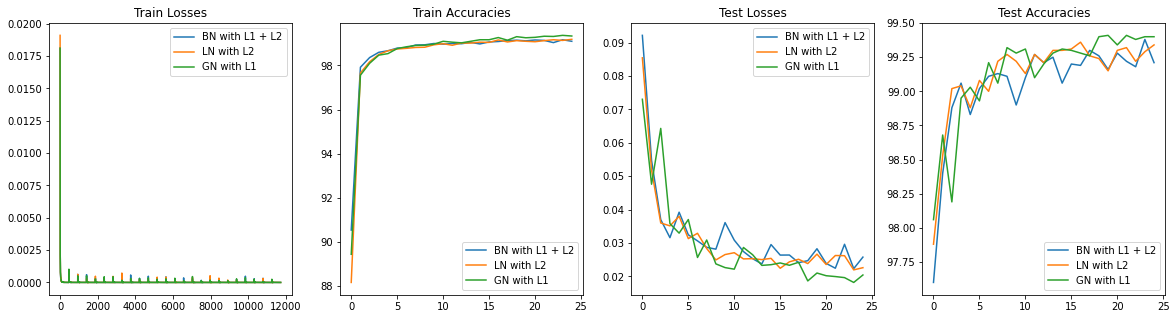

In [32]:
figure = plt.figure(figsize=(20,5))

labels = ['BN with L1 + L2', 'LN with L2', 'GN with L1']
plt.subplot(1,4,1)
plt.title(f"Train Losses")
plt.plot(bn_train_stats.losses, label=labels[0])
plt.plot(ln_train_stats.losses, label=labels[1])
plt.plot(gn_train_stats.losses, label=labels[2])
plt.legend(loc="upper right")

plt.subplot(1,4,2)
plt.title(f"Train Accuracies")
plt.plot(bn_train_stats.accuracy, label=labels[0])
plt.plot(ln_train_stats.accuracy, label=labels[1])
plt.plot(gn_train_stats.accuracy, label=labels[2])
plt.legend(loc="lower right")

plt.subplot(1,4,3)
plt.title(f"Test Losses")
plt.plot(bn_test_stats.losses, label=labels[0])
plt.plot(ln_test_stats.losses, label=labels[1])
plt.plot(gn_test_stats.losses, label=labels[2])
plt.legend(loc="upper right")

plt.subplot(1,4,4)
plt.title(f"Test Accuracies")
plt.plot(bn_test_stats.accuracy, label=labels[0])
plt.plot(ln_test_stats.accuracy, label=labels[1])
plt.plot(gn_test_stats.accuracy, label=labels[2])
plt.legend(loc="lower right")

In [28]:
def plot_misclassified(test_stats, num_images, title, class_names, fig_size, unnorm_mispred):
    
    figure=plt.figure(figsize=fig_size)
    print(f'** Plotting misclassified images from last epoch for {title} **')
    print('\n')
    class_names_dict = class_names
    if len(test_stats.img) > num_images: 
        for i in range(num_images):
            plt.subplot(5,5,i+1)
            plt.axis(False)      
            unnorm = unnorm_mispred.unnorm_gray(test_stats.img[i].squeeze().cpu())
            plt.imshow(unnorm, cmap='gray_r')
            prediction = class_names_dict.get(test_stats.pred[i])
            actual     = class_names_dict.get(test_stats.label[i])
            s="pred="+str(prediction)+" act="+str(actual)
            plt.text(2,-1,s)
    else:
        print(f'Unable to plot - Less than {num_images} images, only have {len(test_stats.img)} images')


** Plotting misclassified images from last epoch for GN + L1 **




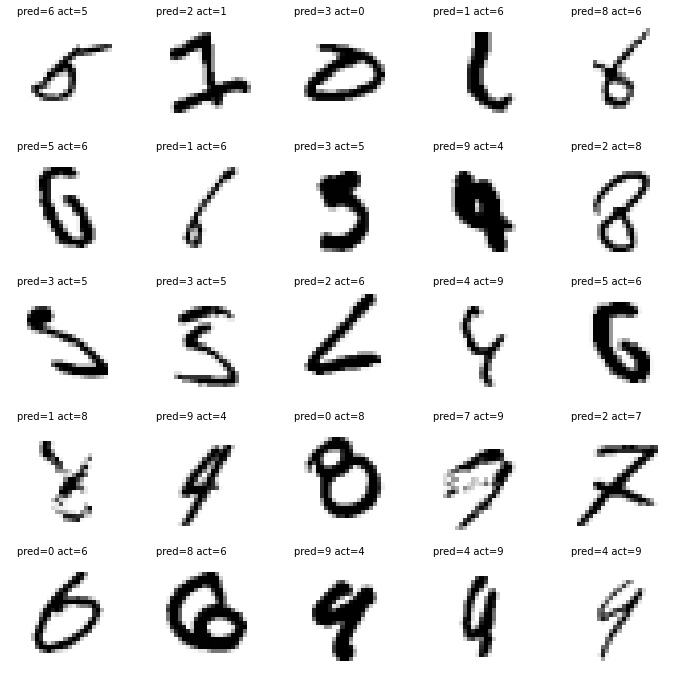

In [29]:
mean  = 0.1307
stdev = 0.3081
unnorm_mispred = utilities.unnorm_img(mean, stdev)
plots = utilities.plots()

class_names_dict = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}
num_images = 25
fig_size = (12, 12)

title = 'GN + L1'
misclass_stats = gn_test_stats
plot_misclassified(misclass_stats, 25, title, class_names_dict, fig_size, unnorm_mispred)

** Plotting misclassified images from last epoch for LN + L2 **




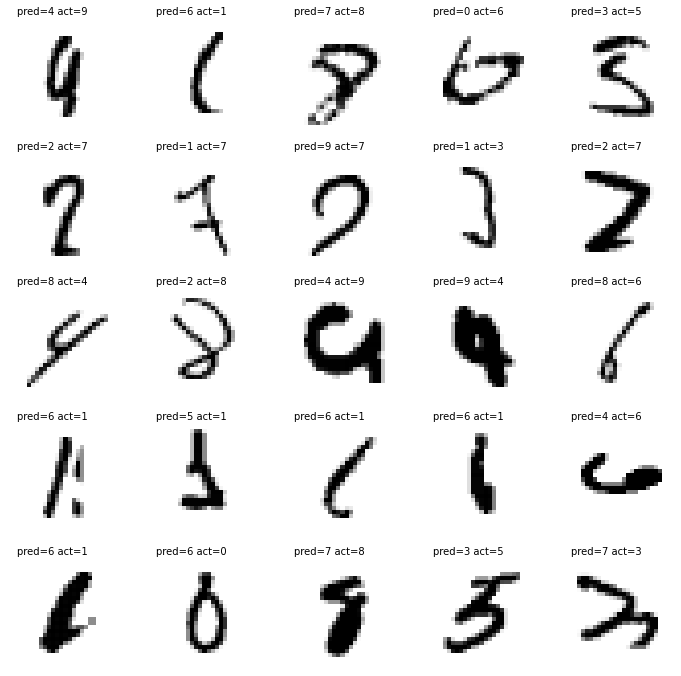

In [30]:
title = 'LN + L2'
misclass_stats = ln_test_stats
plot_misclassified(misclass_stats, 25, title, class_names_dict, fig_size, unnorm_mispred)

** Plotting misclassified images from last epoch for BN + L1 + L2 **




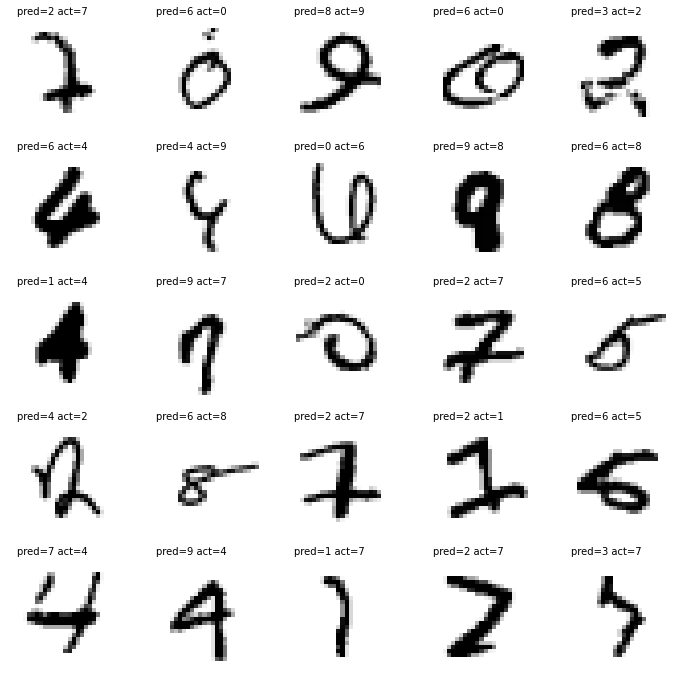

In [31]:
title = 'BN + L1 + L2'
misclass_stats = bn_test_stats
plot_misclassified(misclass_stats, 25, title, class_names_dict, fig_size, unnorm_mispred)

### Learning : How to compare 2 tensors and create a tensor which will store index of unequal values

In [ ]:
a = torch.tensor([2, 3, 2, 3, 2, 3])
b = torch.tensor([2, 2, 2, 2, 2, 2])
c = a.eq(b)
print(c)
d = (c == False).nonzero(as_tuple=True)[0].tolist()
print(d)

tensor([ True, False,  True, False,  True, False])
[1, 3, 5]
